# PHAS0020 Session 5b: Fourier Transforms and Convolutions

_Author: g.savini@uc.ac.uk 02/02/2020_

<div class="alert alert-success">
    
**In this first second script there is a lot to read (and a few tasks to do).**

**Read through all of the Markdown explanations and some of the cells which have been done for you and where you
encounter a green cell, there will be short tasks to do in between**

In this script we aim to:
<ul>
    <li> Review the definition and mathematical expressions for the Fourier Transform</li>
    <li> See how the analytical expression compares to the "Discrete" Fourier transform</li>
    <li> Learn how to perform such a transform practically</li>
    <li> Use the "Fast" Fourier transform (FFT) to do the same</li>
    <li> Transform the result back to the time domain by <em> Inverse FT </em></li>
    <li> Use this by making a practical application of the Convolution Theorem</li>
    <li> Learn about Fourier pairs and how this is used in astronomy to identify instrument beams</li>
</ul>

<br>
Where you find a Task part of the script, don't forget to <b>write a Markdown cell at the start and one at
the end for comments and conclusions.</b>
<br>


</div>

In PHAS0025 (Maths III) you learned about the Fourier Series and the Fourier Transform. In this session we're going to look at methods of using these techniques numerically - and in particular for the Discrete Fourier Transform (often known as the DFT) and the Fast Fourier Transform (FFT), which is a particularly efficient algorithm to implement the DFT.

You'll remember the form of the Fourier transform as given in PHAS0025:

$$ g(\omega) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{+\infty} f(t) e^{-i\omega t} dt $$

and also that its main purpose is to investigate the frequency content of the time domain function through a transformation.
The inverse transform is also true:
$$ f(t) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{+\infty} g(\omega) e^{i\omega t} dt $$

(in fact you can find other definitions due to a degree of arbitrariness in defining the dual space units, in some cases you can find the two definitions with no constant in front of the first and $1/2\pi$ in front of the second, you'll see later that inpython this can be controlled by the keyword "norm")

We can already use numerical techniques here, for example by performing the integration numerically using the trapezoidal rule. But what happens if we don't have full knowledge of $f(t)$ - for example if the data we want to transform is discrete, digital, or sampled only at certain values of $t$? This is where the discrete Fourier transform steps in.

## The discrete Fourier transform (DFT)

We won't cover a full derivation of the DFT here (it is covered in most computational physics textbooks, for example Newman *Computational Physics* Chapter 7, or "Numerical Recipes" by  W.H.Press, S.A. Teukolsky, W.T. Vetterling and B.P. Flannery), but the following gives an outline derivation. 

We'll also use a more general notation $f(x)$ rather than $f(t)$.*

So for now we consider $f(x)$ generically as the results apply broadly.

We already know that we can represent a periodic function in terms of a Fourier series. In general however, we're dealing with functions $f(x)$ that are *non-periodic*. This isn't as problematic as it might seem, as we can take a portion of our non-periodic function over an interval from $0$ to $L$ and repeat it infinitely in both directions to form a periodic function of period $L$. Clearly, the results will be incorrect outside this region, but if the only portion we're interested in is that from $0$ to $L$, all is OK.

In this case, we can represent our function $f(x)$ as a complex Fourier series

$$
f(x) = \sum_{k = -\infty}^{\infty} \gamma_k \exp \left(2 \pi i \frac{k x}{L}\right),
$$
with the coefficients $\gamma_k$ given by
$$ 
\gamma_k = \frac{1}{L} \int_0^L f(x) \exp \left(-2 \pi i \frac{k x}{L}\right) dx.
$$



We can evaluate the integral using the trapezoidal rule with $N$ slices (where $N$ is the number of samples we have for $f(x)$ in the interval $0 < x < L$), which gives us

$$
\gamma_k = 
\frac{1}{N} \sum_{n=0}^{N-1} f(x_n) \exp \left( - 2\pi i \frac{k x_n}{L} \right).
$$


Now if we have a set of sampled data $y_n = f(x_n)$ instead of the full $f(x)$, we can rewrite this as

$$
\gamma_k = \frac{1}{N} \sum_{n=0}^{N-1} y_n \exp \left(- 2\pi i \frac{k n}{N} \right),
$$

as the sampling points $x_n$ are specified by $x_n = n L / N$.

By convention, the factor $1/N$ is dropped from the definition of the discrete Fourier transform (instead, it appears in the inverse discrete Fourier transform), giving the standard form of the **Discrete Fourier Transform**:

$$
c_k = \sum_{n=0}^{N-1} y_n \exp \left(- 2\pi i \frac{k n}{N} \right).
$$

(see, for example, the numpy documentation at http://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft)

But make sure don't forget this $(1/N)$ factor altogether as it is important for normalization purposes.

## The DFT in two dimensions

The same principle holds in two (or more) dimensions. In this case the summation is performed first in one dimension, then in the other. For example, for a two-dimensional $M \times N$ grid of sampled data $y_{mn}$, the DFT becomes

$$
c_{kl} = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} y_{mn} \exp \left( - 2 \pi i \left[ \frac{km}{M} + \frac{ln}{N} \right] \right)
$$

This two-dimensional transform is widely used for image processing, particularly in astronomy.

## Implementing the DFT

Now we've done the theory bit, we can implement the one-dimensional DFT in python fairly simply. We'll start by importing the usual modules:

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy
from astropy.io import fits
import os
from scipy import optimize

plt.rcParams['figure.figsize'] = (15.0, 15.0) # sets the default size for figures

home_dir = os.getcwd()+'/'
print ("The Home Directory is set to:", home_dir) # check the home directory

%matplotlib inline

The Home Directory is set to: C:\Users\safee\Practical Astro Computing\Week 5/


We'll implement the DFT using a function to find the $N$ coefficients we need to describe the function $f(x_n) = y_n$. Bear in mind that our coefficients $c_k$ are, in general, complex. We haven't covered complex numbers in Python much, but fortunately they're fairly easy to cope with. $\sqrt{-1}$ is represented by an engineers' `j` rather than $i$, and in order to represent an imaginary number, you suffix it with a `j`, like this:

In [206]:
1j*1j # calculate i*i 

(-1+0j)

We can see how this works in the following function, which calculates the (complex) coefficients $c_k$ for the DFT:

In [227]:
def dft_1d(y):
    '''Simple implementation of the discrete Fourier transform in 1D
    Input: array of N sample values y
    Output: array of N-1 Fourier coefficients'''
    N = len(y)
    c = np.zeros(N, complex)    # set up an array of complex numbers, filled with 0s
    for k in range(N):          # loop over all N coefficients (runs from 0 to N-1)
        for n in range(N):      # calculate this coefficient.
            c[k] = c[k] + y[n]*np.exp(-2j*np.pi*k*n/N) # 2j: imaginary 2
    return c                    # return an array of coefficients

Let's test this, using a sample from a data file. Make sure you've downloaded the file "pitch.txt" from Moodle, then we'll load it and plot it to see what it looks like.

The data file has  1024  sample points


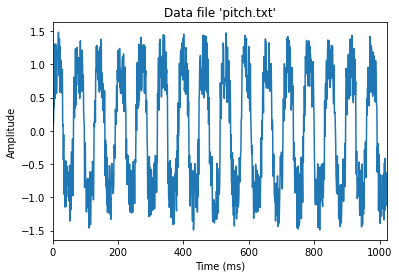

In [228]:
y = np.loadtxt("s5b_pitch.txt",float) # import floats from the data file

print("The data file has ", len(y), " sample points")

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title("Data file 'pitch.txt'")
plt.xlim(0,1024)
plt.plot(y);

We can see that the data represents a function that looks fairly periodic, but quite noisy. Let's transform it, using our function. As the coefficients are complex, we'll plot their absolute value. We'll also only plot the lowest 512 coefficients (corresponding to the lowest frequencies). 
The reason to do this is that given 1024 points, half of the number of points represents the highest frequency we can distinguish without incurring into "aliasing".

In short, "aliasing" is when a frequency higher than the Nyquist frequency is indistinguishable from the lowest which would produce the same sampling. (Think for example that a constant signal can identify a 'dc' signal (frequency=0) but can just as equally identify a signal that has the exact period equal to the sampling interval therefore presenting the same value each time)

If we plot all 1024 points of the spectrum, this becomes apparent as the spectrum is symmetric. We then zoom to the low frequency part of the same plot.

We've calculated 1024 Fourier coefficients


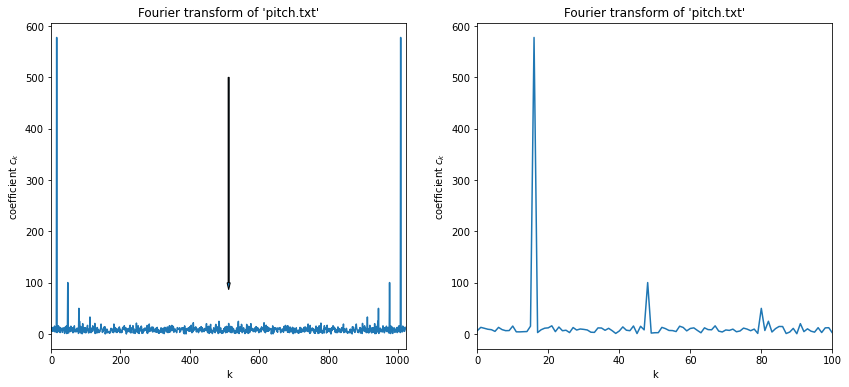

In [229]:
c = dft_1d(y) # calculate the Fourier coefficients

print("We've calculated", len(c), "Fourier coefficients")
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.xlim(0,1024)
plt.plot(abs(c)) # plot the absolute coefficients
plt.title("Fourier transform of 'pitch.txt'")
plt.xlabel('k')
plt.ylabel('coefficient $c_k$');

plt.arrow(512,500,0,-400,width=3)  # Arrow pointing at the Nyquist frequency

plt.subplot(122)
plt.xlim(0,100)
plt.plot(abs(c)) # plot the absolute coefficients
plt.title("Fourier transform of 'pitch.txt'")
plt.xlabel('k')
plt.ylabel('coefficient $c_k$');


We can see that the data does indeed consist of a base frequency, or fundamental, with $k\sim 15$, with a few higher harmonics and plenty of noise from other frequencies. Note that the fundamental frequency is the _lowest_ Fourier component, not necessarily the largest Fourier component. The Fourier components are effectively a "signature" of the sound (for audio data), or the image (for two-dimensional image data) and contain a lot of information.

Maybe you noticed this took a second or two to compute. Let's look at why. In our implementation of the DFT, we have a double loop over $N$, meaning we need to do $N^2$ calculations to do the transform. If $N$ is big, this is going to get very slow very quickly.

## The Fast Fourier Transform



Fortunately, there's already a much more efficient algorithm for this, which is known as the **Fast Fourier Transform** or **FFT**. We're not going to go into the details of this here (if you want to know more, you can read http://dx.doi.org/10.1090/S0025-5718-1965-0178586-1), and even better, it's already implemented in Python, so we don't even need to implement the algorithm ourselves, but can just get on with using it.

(Technical aside: The FFT routines are implemented both in numpy and in scipy. They are slightly different, but for most of the stuff we'll be using them for here it doesn't make any difference, so we'll just use the numpy versions for convenience. You can read more about the relationship between numpy and scipy ("It's complicated") here: http://stackoverflow.com/questions/6200910/relationship-between-scipy-and-numpy?rq=1)


Let's use fft to recalculate the transform of the data we looked at earlier. We'll use the numpy [rfft](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.rfft) routine, which is part of the fft module, to do the transform. The 'r' here is for real - as we are only dealing with real sample functions (there's a corresponding [fft](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.fft) routine which can handle complex functions). Note, however, that the coefficients are complex regardless of whether $f(x)$ is real or complex.

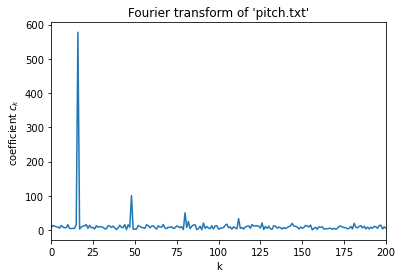

In [230]:
c_fft = np.fft.rfft(y) # transform the original data
                       # note the form of the call -
                       # we're using the numpy rfft routine in the numpy fft submodule

plt.figure()
plt.xlim(0,200)
plt.plot(abs(c_fft))   # plot the absolute coefficients
plt.title("Fourier transform of 'pitch.txt'")
plt.xlabel('k')
plt.ylabel('coefficient $c_k$');

What you should find is that this calculation is almost instantaneous - but it generates identical results.

**Note the operation you just performed which moves from the time domain to the frequency space can be performed backwards!**

This is a general fourier transform property and can be performed using our function or FFT, let us use the faster FFT routine to do so this way

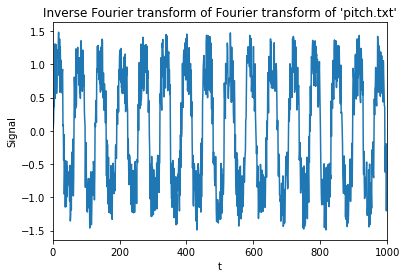

In [231]:
y2 = np.fft.irfft(c_fft)   # transform the fft previously calculated
                           # note the form of the call -
                           # we're using the numpy irfft (the extra "i" indicates "inverse")routine in the numpy fft submodule

plt.figure()
plt.xlim(0,1000)
plt.plot(y2)   # plot the absolute coefficients
plt.title("Inverse Fourier transform of Fourier transform of 'pitch.txt'")
plt.xlabel('t')
plt.ylabel('Signal');

We obtained our signal again as the two operations switch between the dual spaces and are reversible

<hr>

## Short Task 1 - Apply a filter in Frequency space

<div class="alert alert-success">
    
<b> Using what you learned in previous sessions. Create a few cells below this one where you:</b>

<ol type='a'>
    <li> Define a generic Low Pass filter function (Task 4)</li>
    <li> Use this function to create a filter that cuts off all harmonics higher than the first (of the data transformed above). Do this by choosing the frequency where you want the cut-off to take place.</li>
    <li> Apply the filter (multiply the Fourier transform of the data you have above by the filter)</li>
    <li> Transform the result back to the time domain by <em> Inverse FT </em></li>
</ol>

</div>

The Low-Pass function is defined as:
$$ f_{LP}(x) = \frac{h}{1+\bigl(\frac{x}{x_1}\bigr)^p} \ \ \ $$

In [232]:
#Function for Low-Pass filter is defined below.

def LP(x, x1, p, hg):                         #hg = height of peak , x1 = starting point of peak , p = arbitrary value
    
    LP = hg/(1 + (x/x1)**p)
    
    return LP

<ipython-input-232-3bcee3dea5d3>:5: RuntimeWarning: divide by zero encountered in power
  LP = hg/(1 + (x/x1)**p)


Text(0, 0.5, 'coefficient $c_k$')

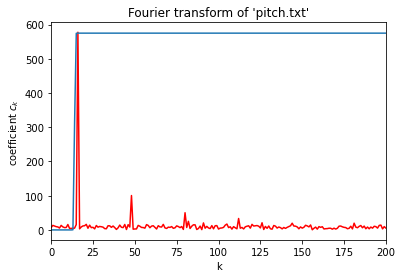

In [233]:
x = np.linspace(0,len(abs(c_fft)),len(abs(c_fft)))                 #Generate x-values for plot

plt.plot(abs(c_fft),'-r')                                          #Plot the data we are using filter for.

#Input values for the LP function
p = -100
x1 = 14               
hg = 575

plt.plot(x, LP(x, x1, p, hg))                                      #Plot the fiter on the graph

plt.xlim(0,200)                                 #Limit x-axis from 0 to 200 to be able to see important parts easily.

plt.title("Fourier transform of 'pitch.txt'")
plt.xlabel('k')
plt.ylabel('coefficient $c_k$')

Text(0, 0.5, 'coefficient $c_k$')

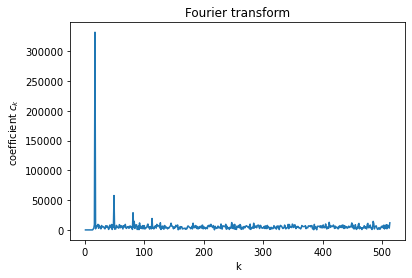

In [234]:
x = np.linspace(1,len(abs(c_fft)),len(abs(c_fft)))                 #Generate x-values for plot
y = abs(c_fft)*LP(x, x1, p, hg)                                    
plt.plot(x,y)

plt.title("Fourier transform")
plt.xlabel('k')
plt.ylabel('coefficient $c_k$')

Text(0, 0.5, 'Signal')

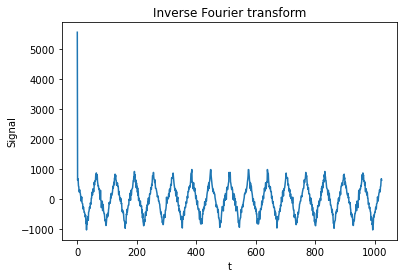

In [239]:
y3 = np.fft.irfft(y)   # Inverse transform the above fourier transform.

plt.figure()
plt.plot(y3)     
plt.title("Inverse Fourier transform")
plt.xlabel('t')
plt.ylabel('Signal')

##### STUDENT MARKDOWN CELL ######
There is a big peak at the start of the last graph at a point where the previous graph also had a peak, which tells me that they exist for the same reasons.

### 2D FFT

Let us load a portion of a sky image now from the fits file on Moodle. We will do this for you below.

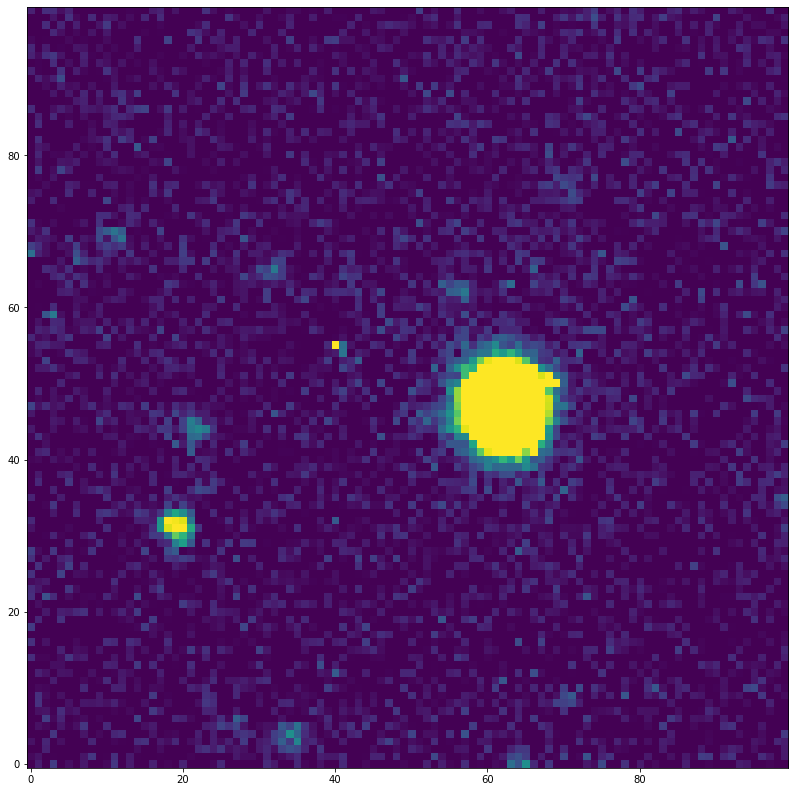

In [255]:
from astropy.io import fits

fits_image_filename = 's5b_image.fits'
HDUlist = fits.open(fits_image_filename)
large = HDUlist[0].data                     # As this fits file was created just to grab a small frame of an image, 
                                             # There is no header associated with it so the first and only element (0)
                                             # is the image we need

# For the simple purpose of visualizing the stars, let us set all points below the image median equal to 0      
w = np.where(large < np.median(large))
large[w] = np.median(large)
large    = large  -  np.median(large)

#...and then normalize the image to 1 at the highest peak
large = large/np.max(large)

plt.rcParams['figure.figsize'] = 14,14 
plt.imshow(large,origin='lower',vmin=0,vmax=0.01)    # We then visualize the image by using our entire dynamic range
                                                        # for the bottom 0.1% of values

Make a mental note of all the features that can be seen in this image. If you wish, re-run the previous cell by changing <tt>vmin</tt> and <tt>vmax</tt> to see where the brighter sources are. The default on the script you downloaded is at 1% from the image median.

Let us now apply the 2D FFT to the image above according to the description above.

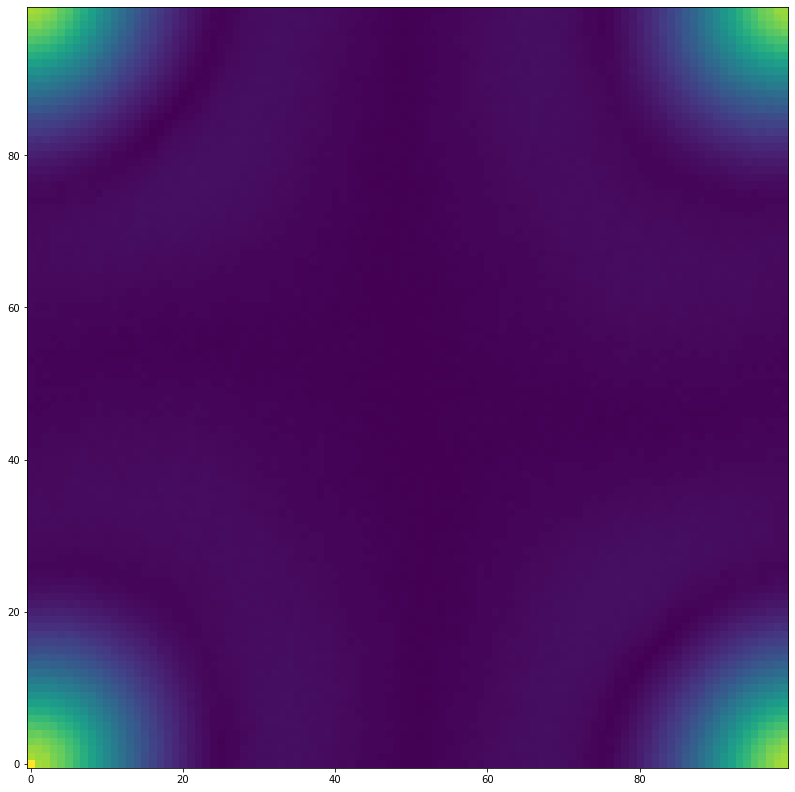

In [256]:
image_fft = np.fft.fft2(large,norm=None) # transform the 2d data
                            # we're using the numpy rfft2 routine in the numpy fft submodule

# Let's visualize the absolute value of the otherwise complex fft
plt.imshow(abs(image_fft),origin='lower')


Note how the information on the low frequencies (as in the 1D case) is centred close to the origin (0,0), but now the symmetry occurs in 2 dimensions. 

Let us re-arrange this array so that the (0,0) or origin of our 2D FT is placed at the centre of the array. This is done in a tedious way by swapping quadrants with a temporary array.

Re-centered the FFT


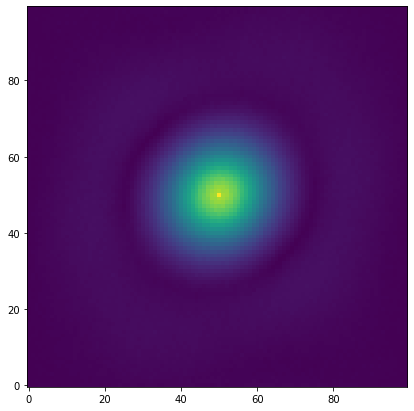

In [257]:
shape = image_fft.shape
sz = int(shape[0]/2)
temp = np.zeros((2*sz,2*sz),dtype=complex)

print('Re-centered the FFT')
temp[sz:,sz:]=image_fft[:sz,:sz]
temp[:sz,:sz]=image_fft[sz:,sz:]
temp[:sz,sz:]=image_fft[sz:,:sz]
temp[sz:,:sz]=image_fft[:sz,sz:]
plt.rcParams['figure.figsize'] = 14,7 
plt.figure()                              # You should see below the image (left) compared to the fit (right)
#plt.subplot(121)
plt.imshow(abs(temp),origin='lower')
#plt.title('Range: 0-100')
#plt.subplot(122)
#plt.imshow(abs(temp),origin='lower',vmin=20.0,vmax=np.max(abs(temp)))
#plt.title('Range: 100-200')


## Short Task 2 - Apply a filter in Frequency space

To avoid excessive complications, in the cell below you will find the a very familiar function that defines a symmetric gaussian. 

Following that there are a few lines that create a set of x and y variables of the same size of the image loaded.

In the cell below that, a 2D gaussian is created and called "LP_filter" with a sigma of 15 (but you can change the value if you wish) and is placed at the centre of the image.

<div class="alert alert-success">
    
1. Apply it (multiply) to the image's FT and inverse transform that product as is done in the 1D case (but remember to rearrange the tiles before inverse transforming to observe the output image.

2. As defined, the function will have a peak at 1 and will tend to zero at infinity and will serve as your Low pass filter. Now define an equivalent High Pass filter (i.e. 0 in the center and 1 at infinity) and repeat the operation.

3. At the end of these 3 steps you should have the image and a Low-pass and High-pass filtered versions of it. Compare them by outputting them side-by-side in a 1x3 set of plots.

</div>

In [258]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def gauss_2D(x,y,x0,y0,sigma):
    '''Returns a symmetric 2D gaussian with a given sigma value
    - input x0,y0 - the center of the gaussian
    - sigma : the symmetric sigma of the gaussian'''
    g2d = np.exp(-((x-x0)**2+(y-y0)**2)/(2*sigma**2)) # gaussian normalized to 1 at its peak
    return g2d

#Creation of x and y variables with size (2sz x 2sz) so that the center of the image has coordinates (sz,sz)
tmp  = np.linspace(0,2*sz,4*sz*sz)
tmp2 = np.reshape(tmp,(2*sz,2*sz))
yy = np.floor(tmp2)
tmp3 = 2*sz*(tmp2-yy)
xx = np.floor(tmp3)

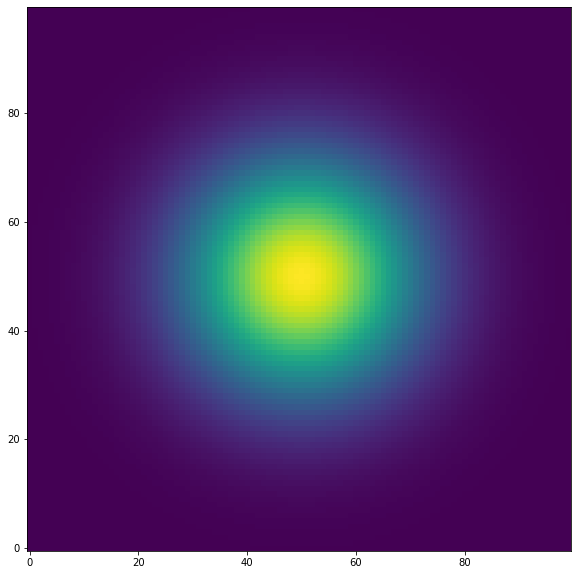

In [259]:
LP_Filter = gauss_2D(xx,yy,sz,sz,15.0) 

# Let's image this to make sure it's what we want 
plt.figure(figsize=(10,10))
plt.imshow(LP_Filter, origin='lower') 


In [ ]:
### STUDENT CELL 2.1 ###

In [ ]:
### STUDENT CELL 2.2 ###

In [ ]:
### STUDENT CELL 2.3 ###

Now that we have seen 1d and 2d Fourier Transforms, we have the primary ingredient to understand...

### CONVOLUTION ###

In functional analysis, the operation of convolution describes a mathematical operator between two functions that creates a third as a result of a shifted integral. 

In practice it creates a function that shows how one function is modified by the other. This modification is sometimes referred to as "smoothed" because convolution is often performed with regular functions, but that not need be always the case.

In maths, the operation of convolution will be represented by

$$ f*g \rightarrow (f * g)(x) = \int ^{\infty} _{-\infty} f(x')g(x-x')dx' = \int ^{\infty} _{-\infty} f(x-x')g(x')dx'$$

sometimes the $\circledast  $ is also used in place of $*$. 

You can check the <em><a href='https://en.wikipedia.org/wiki/Convolution'> Convolution</a></em> page on wikipedia for
some intuitive animated gifs showing how (1D) convolution in time produces convolved time response functions and for a full list of convolution properties.

Here we will focus on one in particular aspect which is called the "Convolution theorem".

The <b> Convolution theorem </b> states that <em> the Fourier transform of the convolution of two functions is proportional to the product of the Fourier transforms of the two functions.</em> Or otherwise

$$ \mathscr{F}(f*g) \propto \mathscr{F}(f)\cdot\mathscr{F}(g)$$

(In fact it would be "equal" other than it is multiplied by a normalization constant that depends on the specific normalization of the Fourier transforms). Using $\mathscr{F}$ to represent a Fourier transform.

Why is this important? Because it allows us to replace the complex procedure of convolution (or deconvolution) by a simple multiplication (or division)*.

(*) Not without its issues...

For example, let's say we wanted to observe a point source in the sky with a telescope that has a given beam which we can represent with a gaussian, we would observe the convolution of a given field of point sources in the sky, with such a gaussian. This would be a tedious operation, but can be (in principle) handled by a simple pair of Fourier transforms and a product.

#### PRACTICAL EXAMPLE

In point of fact, let us consider the image we used a while ago as if it were the true representation of the objects in the sky (i.e. viewed with a telescope of "infinite size" but very poor efficiency).
Let us then assume that we have a telescope beam which is expressed by a gaussian of a certain size (let's say a small number in pixel size, like a FWHM = 1.1)
[FWHM = Full-Width at Half-Maximum]

Let us define a small array of points that describes such a gaussian. We won't need this to be large array given the size of the function (say 11x11).

In [ ]:
#We can use the same gaussian function used earlier:
sz = 11
tmp  = np.linspace(0,sz,sz*sz)
tmp2 = np.reshape(tmp,(sz,sz))
yy = np.floor(tmp2)
tmp3 = sz*(tmp2-yy)
xx = np.floor(tmp3)

beam = gauss_2D(xx,yy,(sz-1)/2,(sz-1)/2,1.0) 

# Let's image this to make sure it's what we want 
plt.figure()                              
plt.imshow(beam, origin='lower') 


Now, if we wanted to perform a convolution in 2D of the original image with this array, we'd have to proceed as follows:
<ol>
    <li> Extend the original array by the size of the conolving array*</li>
    <li> Create a new array for the convolved image where each element is the result of the integral of the product of the overlap of this array on the other image placed accordingly**</li>
</ol>

(*) The first point to recognize is that in a convolution one needs to satisfy an appropriate border condition or make certain assumptions. If one adopts the 1D expression literally, then the two images that are convolved could be infinitely extended making things very complicated. Here we assume that anywhere outside both our image and our kernel, these images are $=0$ allowing us to reduce the limits of our integral (or in our case the extent of our array sums).

(**) The second point is the point of application. In many 1D cases (especially time convolution), one has to specify if the convolution occurs at one end of the kernel used for the convolution or at the center... this is just a matter of definition and impacts only as a shift to the final result (hence the importance in the time domain.


In [ ]:
shape = large.shape
sz = int(shape[0])
temp = np.zeros((sz+22,sz+22),dtype=float)

temp[11:11+sz,11:11+sz]=large
plt.rcParams['figure.figsize'] = 15,7 
plt.figure()                              # You should see below the image (left) compared to the fit (right)
plt.subplot(131)
plt.imshow(temp,origin='lower',vmin=0,vmax=0.01) 

#Now let's create the convolved host array
convolved = np.zeros((sz+22,sz+22),dtype=float)

normz = np.sum(beam)
for kx in range(sz+11):
    for ky in range(sz+11):
        convolved[kx+5,ky+5] = np.sum(temp[kx:11+kx,ky:11+ky]*beam)/normz

plt.subplot(132)
plt.imshow(convolved[11:sz+11,11:sz+11],origin='lower',vmin=0,vmax=0.01) 

###             
# TO DIRECTLY COMPARE YOUR LOW PASS FILTERED IMAGE, PUT THE NAME OF THE VARIABLE YOU USED FOR IT
# IN THE SUBPLOT BELOW AND UNCOMMENT IT
###
#plt.subplot(133)
#plt.imshow(abs(LP_filtered_image), origin='lower',vmin=0,vmax=0.01) 
#plt.title('Low-Pass filtered image')


This looks remarkably similar to the Low Pass filtered image we already obtained... how is this possible?

Let us see if the Convolution theorem helps with this:

We have just convolved our image (let us call the image "$g$") with a kernel or "beam" ("$b$") which has been shifted across the image and integrated. So according to our notation we can write this as
$$(g*b)$$ 
while the filtered image is the Fourier transform of the product of the Fourier transform of the image ($G=\mathscr{F}(g)$) and a 2D-filter $F$. So we can equally write this as 
$$\mathscr{F}(G\cdot F)$$

If these two are equal (and recalling that the Fourier transform of a Fourier transform brings you back to the original function (with the appropriate normalization constants), we can rewrite this as:

$$(g*b) = \mathscr{F}(G\cdot F)$$

and Fourier transforming both sides

$$\mathscr{F}(g*b) = G\cdot F$$

which due to the convolution theorem implies that this is possible only if the 2D frequency filter $F=\mathscr{F}(b)$ is the Fourier transform of the beam. Let us check if this is close to being true... by Fourier transforming our Filter and comparing it with our convolving beam.

In [ ]:
#We still have the function "LP_filter" so we can plot this and compare it's Fourier transform to the
# small beam function (placed in a larger array only for comparison in the side-by-side plots)

plt.figure()                              
plt.subplot(131)
plt.imshow(LP_Filter, origin='lower') 
                           

beam_fft = np.fft.fft2(LP_Filter)
#remember we need to do the tedious re-tiling

#Now the same for the HP
shape = beam_fft.shape
sz = int(shape[0]/2)
btemp = np.zeros((2*sz,2*sz),dtype=complex)
btemp[sz:,sz:]=beam_fft[:sz,:sz]
btemp[:sz,:sz]=beam_fft[sz:,sz:]
btemp[:sz,sz:]=beam_fft[sz:,:sz]
btemp[sz:,:sz]=beam_fft[:sz,sz:]

btemp = btemp/np.max(btemp)

ctemp = np.zeros((2*sz,2*sz),dtype=float)
ctemp[sz-5:sz+6,sz-5:sz+6] = beam

plt.subplot(132)
plt.imshow(abs(btemp),origin='lower')
plt.subplot(133)
plt.imshow(ctemp,origin='lower')

## Short Task 3 - Comments and deconvolution.
<div class="alert alert-success">

1. Aside from having just "experienced" the Convolution theorem by applying it directly to imaging. Comment on all aspects of this process.

2. Consider the fact that deconvolution follows the same (but inverted) logic.

3. Try and perform a simple deconvolution (reversing the steps and making sure that the Convolution theorem is still followed).

4. What comments or conclusions can you state after attempting to perform it (or even ahead of this knowing what it entails).
</div>

In [ ]:
### STUDENT CELLS ###

#### STUDENT MARKDOWN CELL ####

## Diffraction and the Airy Disc

The other thing we noticed is that the Fourier Transform of a Gaussian is still a Gaussian!

This is true and points to the fact that <b> Fourier Transform pairs </b> are another important concept that has other astronomical implications... more specifically in instrumentation.

For example, the Fourier transform of a circle disc 
$$ f(r) = 1 ; r\le R $$
$$ f(r) = 0 ; r>R $$
is an Airy function which is often expressed as:
$$ A(\theta) = A_0 \biggl[ \frac{2J_1(\tilde{x})}{\tilde{x}} \biggr] ^2   ;   \tilde{x} = 2\pi R \sin(\theta)/\lambda $$

If you recall your diffraction limit... now you start to see, given that the diameter $D=2R$ where the $\lambda / D$ is coming from... and if you plot it you can also see where the $1.22$ factor comes from.
This is done in the cell below for you.

In [ ]:
import scipy.special as scy
x = np.arange(-3,3,0.1)
airy = (scy.jv(1,x*np.pi)/(x*np.pi))**2
plt.plot(x,airy,'r')
plt.title('Not so much a carefully scaled plot - just a shape reminder')
plt.xticks(np.arange(-3,3,step=0.2))
plt.ylim(0,np.max(airy))

Of course the Airy function is not exactly a comforable function to use... so we tend to approximate this to a Gaussian... moreover, when dealing with ground based telescopes, seeing gets in the way anyway, so the approximation is not so bad.

## Short Task 4 - Comments and Gaussian fit.
<div class="alert alert-success">

1. Comment on why, if the Airy disc is the Fourier transform of a disk, it represents the closest psf if unaltered by seeing.

2. Use previously written code (Session 2) to fit a gaussian to this shape and compare the FWHM to work out the error we commit in this approximation.
</div>

#### STUDENT MARKDOWN CELL ####

In [ ]:
### STUDENT CELLS ###

In what follows is an explanation of how to perform the fitting of a 2D function (which is somewhat tedious due to the inherent 1D nature of the statistical fit routine used). All of this is done for you and is incredibly useful - and important - for the final python task.

In the last session (4) we saw how to fit 1-D functions and to manipulate the outcomes in different ways (normalization, integration and other combinations). 
The two dimensional equivalent is conceptually the same exercise, but involves two dimensionaly arrays. 

As always let us import the same set of modules that we are likely to need (you can always come back to this cell and add more and re-run the Kernel if you need to.
Check the demonstration python file "d5_PHAS0020-Session5-MorePlotTypes" on Moodle to add the necessary module for 3D plots that might come in handy, and more in general to look at a whole range of interesting ways to plot 2D data.

In [ ]:
import statistics as stats
from scipy import optimize

#To introduce a range of 3D plots, we need to import another library
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### What is a Point Spread Function and why is it relevant to astronomy ###
Details on PSFs and how they relate to astronomy and astronomical instrumentation can be found in almost every text of observational astronomy. You can find some additional information on:

D. Scott Birney, G. Gonzalez, D. Oesper, Observational Astronomy (2nd edition), ISBN 0 521
853705 (Cambridge University Press, 2006) – Also available online at UCL-Explore

or

F. Chromey, To Measure the Sky: An Introduction to Observational Astronomy (2nd Edition),
ISBN: 978-1-107-572560 (Cambridge University Press, 2016). ) – Also available online at UCLExplore

But the single best definition that can suit our initial purpose can be borrowed by <a href='https://en.wikipedia.org/wiki/Point_spread_function'> Wikipedia </a> and is:

<em>"The point spread function (PSF) describes the response of an imaging system to a point source or point object."</em>

We will get to the details of how the psf is generated, but for now let us look at this from an empirical point and simply observe how the response to a point source (in our case a star- which is as "point-like" as it gets) is often dominated by the <a href='https://en.wikipedia.org/wiki/Astronomical_seeing#The_full_width_at_half_maximum_(FWHM)_of_the_seeing_disc'>astronomical "seeing"</a> of the site rather than from instrumental features.

For now, we are interested in the final seeing disc that is obtained in an image.

As such let us consider a small portion of an image taken at UCLO where we have isolated a relatively bright star.

In [ ]:
# Let us start from a (by now) familiar function: a gaussian
# To define this properly we will need to create the 2D equivalent of our usual 1D x vectors.
# This can be done in a few ways, here we will use that which is explained in detail in 
# the "MorePlotTypes" notebook I have made available on Moodle.
size=100
temp  = np.linspace(0,size,size*size)
temp2 = np.reshape(temp,(size,size))
yy = np.floor(temp2)
temp3 = size*(temp2-yy)
xx = np.floor(temp3)

#We can now use an easily defined gaussian to create our 2D function:

def gauss_2D(x,y,x0,y0,sigma):
    '''Returns a symmetric 2D gaussian with a given sigma value
    - input x0,y0 - the center of the gaussian
    - sigma : the symmetric sigma of the gaussian'''
    g2d = np.exp(-((x-x0)**2+(y-y0)**2)/(2*sigma^2)) # gaussian normalized to 1 at its peak
    return g2d

Gauss_test = gauss_2D(xx,yy,40,40,20) 
# We can then plot this in an image or a contour plot:
plt.figure()
plt.subplot(121)
plt.imshow(Gauss_test, origin='lower') 
plt.subplot(122)

plt.contour(xx,yy,Gauss_test,levels=[0.001,0.01,0.1,0.2,0.5,0.99,0.999])
# or uncomment the following two lines to ask for a set of contour 
# lines equally spaced according to the range of the data to be plotted
#
#ncontours=10
#plt.contour(xx,yy,Gauss_test,ncontours)

plt.grid()                 # include gridlines on the plot.
plt.axis('scaled')         # aspect ratio 1:1

In [ ]:
plt.rcParams['figure.figsize'] = 15,8
fig = plt.figure()
ax = fig.add_subplot(1,2,1, projection='3d')
ax = fig.gca(projection='3d')
msurf = ax.plot_wireframe(xx, yy, Gauss_test, rstride=2, cstride=2)
ax = fig.add_subplot(1,2,2, projection='3d')
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, Gauss_test, cmap=cm.coolwarm)
plt.show

### Task 5 - Finding the PSF/seeing of a given image ###
While it is more common to talk about PSF in relation to a given instrument, many ground based telescopes have a psf which is dominated by "seeing". As the seeing is itself dependent on atmospheric conditions, it is not a constant of a given system or telescope and therefore cannot be singularly identified for such system but can be referred to a given image.

<div class="alert alert-success"> 
Task 5a:
    <ol>
        <li> Read Part 1. A more generic 2D gaussian is defined below to be able to fit the most 
            generic gaussian possible. </li>
        <li> Look at the definition and then add an appropriate Markdown cell above the cell with the function correctly defined.</li> 
    </ol>
</div>

In [ ]:
# Let us import the necessary modules to read in a small fits file (with no header)
from astropy.io import fits

fits_image_filename = 's5b_image.fits'
HDUlist = fits.open(fits_image_filename)
image1 = HDUlist[0].data                     # As this fits file was created just to grab a small frame of an image, 
                                             # There is no header associated with it so the first and only element (0)
                                             # is the image we need
image1 = image1-np.min(image1)
image1 = image1/np.max(image1)
plt.imshow(image1,origin='lower')

As we see there is only one dominant star here so we can try and fit a gaussian to this to check the size and position of this

##### STUDENT MARKDOWN CELL  

In [ ]:
## In addition to having defined the function for you, and because of how optimize works (inherently in 1D) we need 
### to ravel the data (or flatten it) and the same goes for the function which needs redifining with a slight add-on

def Gauss2D(x, mux, muy, sigmax, sigmay, amplitude, offset, rotation):
    assert len(x) == 2
    X = x[0]
    Y = x[1]
    A = (np.cos(rotation)**2)/(2*sigmax**2) + (np.sin(rotation)**2)/(2*sigmay**2)
    B = (np.sin(rotation*2))/(4*sigmay**2) - (np.sin(2*rotation))/(4*sigmax**2)
    C = (np.sin(rotation)**2)/(2*sigmax**2) + (np.cos(rotation)**2)/(2*sigmay**2)
    G = amplitude*np.exp(-((A * (X - mux) ** 2) + (2 * B * (X - mux) * (Y - muy)) + (C * (Y - muy) ** 2))) + offset
    return G.ravel()

### This has now returned a "G" which is 1D as a raster scan of our 2D function
###-----------------------------------------------------------------------------
### Let us now create an array of similarly unpacked x and y data to act as the x and y coordinates of the image

x1d = np.arange(100, dtype=float)   # A 1D array of N side
y1d = np.arange(100, dtype=float)   # A 1D array of N side
xx , yy = np.meshgrid(x1d, y1d)     # Two unpacked 2D arrays NxN with both set of coordinates.

size = xx.shape
x = np.vstack((xx.ravel(), yy.ravel()))   # A 2xN^2 array with the pair of coordinates corresponding to the unpacked data.
y = image1.ravel()                        # Unpacked data (1xN^2)

po = np.asarray([60.,45., 3., 3., 1.0, 0., 0.], dtype=float) #Build the array of parameters for initial guess

popt,pcov = optimize.curve_fit(Gauss2D, x, y, po) #Use our generic 2D gaussian fit and fit the data.
print('Optimized Parameters :',popt)

z_fit_1d = Gauss2D(x, *popt)              # Create the unpacked fit
Z_fit = z_fit_1d.reshape(size)            # Reshape it as the original NxN

plt.figure()                              # You should see below the image (left) compared to the fit (right)
plt.subplot(121)
plt.imshow(image1, origin='lower') 
plt.subplot(122)
plt.imshow(Z_fit, origin='lower') 

A moment of reflection:

The process which is underlying in the "black box" of the optimization routine is the same Least Square optimization which can be viewed in more detail here.

In [ ]:
# Let us get a little "closer" to the star and check our fit by repeating the same procedure:

side = 21
cenx = np.round(popt[0])
ceny = np.round(popt[1])
subset = image1[int(ceny-side/2):int(ceny+side/2),int(cenx-side/2):int(cenx+side/2)]

x1d = np.arange(side, dtype=float)
y1d = np.arange(side, dtype=float)
xx, yy = np.meshgrid(x1d, y1d)
size = xx.shape
fx = np.vstack((xx.ravel(), yy.ravel()))
fy = subset.ravel()

po = np.asarray([side/2,side/2, popt[2], popt[3], popt[4], popt[5], popt[6]], dtype=float)

popt2,pcov2 = optimize.curve_fit(Gauss2D, fx, fy, po)

z_fit_1d = Gauss2D(fx, *popt2)
Z_fit2 = z_fit_1d.reshape(size)

plt.figure()
plt.subplot(121)
plt.imshow(subset, origin='lower') 
plt.subplot(122)
plt.imshow(Z_fit2, origin='lower') 

We can also view this by overlapping image and the contour as overlay. On the right a surface plot of the fit is shown.

In [ ]:
#contours = plt.contour(X, Y, Z, 3, colors='black')
#plt.clabel(contours, inline=True, fontsize=8)
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
contour = plt.contour(xx,yy,Z_fit2, 6, colors='black')
plt.imshow(subset, extent=[0, 20, 0, 20], origin='lower', cmap='gist_rainbow', alpha=0.5)
plt.colorbar()
plt.axis(aspect='image');
ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(xx,yy,subset, cmap="gist_rainbow", lw=0.5, rstride=1, cstride=1)
ax.contour(xx,yy,Z_fit2, 10, cmap="gist_rainbow", linestyles="solid", offset=1.2)
plt.show()

plt.show

Let us look in detail at the parameter outputs and how they compare to the figure above.
If you've defined the function correctly earlier
<div class="alert alert-success"> 
Task 5b:
    <ol>
        <li> Replace the String "Par.." in the cell below for each parameter with an appropriate string that addresses the parameter correctly. The first one has been done for you as an example. </li>
    </ol>
</div>

In [ ]:
### STUDENT TO MODIFY STRINGS HERE ###
print('List of Parameter outputs')
print('-------------------------')
print('x-coordinate of fitted gaussian peak:','{:2.2f}'.format(popt2[0]))
print('Par 2:',popt2[1])
print('Par 3:',popt2[2])
print('Par 4:',popt2[3])
print('Par 5:',popt2[4])
print('Par 6:',popt2[5])
print('Par 7:',popt2[6])


Now let us take a deeper look at the entire image by lowering the visual threshold (i.e. looking at the lowest 10% of the image value range.

In [ ]:
fits_image_filename = 's5b_large_image.fits'
HDUlist = fits.open(fits_image_filename)
large = HDUlist[0].data                     # As this fits file was created just to grab a small frame of an image, 
                                             # There is no header associated with it so the first and only element (0)
                                             # is the image we need

w = np.where(large < np.median(large))
large[w] = np.median(large)
large = large/np.max(large)

#Take a subset 300x300
subset = large[500:799,800:1099]
plt.imshow(subset,origin='lower',vmin=0,vmax=0.1)


In the following cell we iterate through the stars in a "destructive" way. We do this by:
1. Finding the peak of the image
2. Isolating a small "stamp" or subset image around those coordinates
3. Performing the same fit done above
4. replacing that "stamp" in the original image with a flat array equal to the image median (so that the next highest star will noe be the peak)
5. Repeat steps from 1 to 4.

In [ ]:
large = HDUlist[0].data  
w = np.where(large < np.median(large))
large[w] = np.median(large)
large = large/np.max(large)

#Take a subset 300x300
bsize=300
y0 = 500
x0 = 800
subset = large[y0:y0+bsize-1,x0:x0+bsize-1]

k = 0
box = 21
plt.rcParams['figure.figsize'] = 14,7

#create a host array
sig_x = []
sig_y = []
theta = []
while k < 3:
    k = k +1
    wmax = np.where(subset[box:bsize-box,box:bsize-box] == np.max(subset[box:bsize-box,box:bsize-box]))
    cenx = np.round(wmax[0])+box
    ceny = np.round(wmax[1])+box
    print('# ',k,cenx,ceny)
    stamp = subset[int(cenx[0]-box/2):int(cenx[0]+box/2),int(ceny[0]-box/2):int(ceny[0]+box/2)]
    x1d = np.arange(box, dtype=float)
    y1d = np.arange(box, dtype=float)
    
    xx, yy = np.meshgrid(x1d, y1d)
    size = xx.shape
    fx = np.vstack((xx.ravel(), yy.ravel()))
    fy = stamp.ravel()
    
    po = np.asarray([side/2,side/2, popt[2], popt[3], popt[4], popt[5], popt[6]], dtype=float)

    popt2,pcov2 = optimize.curve_fit(Gauss2D, fx, fy, po)

    z_fit_1d = Gauss2D(fx, *popt2)
    Z_fit2 = z_fit_1d.reshape(size)
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    contour = plt.contour(xx,yy,Z_fit2, 6, colors='black')
    plt.imshow(stamp, extent=[0, box-1, 0, box-1], origin='lower', cmap='gist_rainbow', alpha=0.5)
    plt.colorbar()
    plt.title('$h=$'+'{:2.3}'.format(popt2[4])+'; $x_0=$'+str(cenx[0])+'; $y_0=$'+str(ceny[0])+ \
              '; $\sigma _x =$'+'{:2.2}'.format(popt2[2])+'; $\sigma _y =$'+'{:2.2}'.format(popt2[3]))
    plt.axis(aspect='image');
    ax = fig.add_subplot(1,2,2)
    plt.imshow(subset,origin='lower',vmin=0,vmax=0.1,cmap='gist_rainbow')
    plt.arrow(ceny[0]+20,cenx[0]+20,-15,-15,head_width=3)
    plt.show
    
    subset[int(cenx[0]-box/2):int(cenx[0]+box/2),int(ceny[0]-box/2):int(ceny[0]+box/2)] = np.median(subset)
    sig_x.append(popt2[2]) 
    sig_y.append(popt2[3]) 
    theta.append(popt2[6]) 

In the above cell, we performed this for the 3 brightest stars. 

<div class="alert alert-success"> 
Task 5c (FINAL! Yay!):
    <ol>
        <li> Add all the relevant comments to the code in the cell above. </li>
        <li> Change the loop to perform this a larger number of times (10 should work, but try >10 unless there are error messages</li>
        List holders have been created that extract the relevant parameter fits for you. 
        <li> Make a plot in the cell below of sigX and sig_y vs star number (or index of the loop) and a similar plot for theta and comment on what you see.</li>   
    </ol>
</div>

In [ ]:
plt.figure()
plt.subplot(121)
plt.plot(sig_x)
plt.plot(sig_y,'r')

plt.subplot(122)
plt.plot(theta)


<div class="alert alert-warning">
*EXTRA CHALLENGES - Not Marked*

<ol>    
<li> Test consistency of psf with amplitude. Go back (or copy below the cells above) and extend this to a larger number of stars. (you might even consider using the entire image) and see if (excluding the outliers) there is a trend to the psf size tied to amplitude.</li>
<li> Consider finding a way to represent the values of theta as a function of their position on the image. Is there any apparent pattern?</li>
</ol>
</div>